### Imports

In [1]:
import sys
import json
import time
import requests
import pandas as pd
import matplotlib.pyplot as plt

from datetime import datetime, timedelta
from tqdm.notebook import tqdm_notebook as tqdm

### Constants

In [2]:
SUBREDDIT = 'roastme'
MIN_AGE = 7
SUBMISSION_KEY_WHITELIST = [
    'created_utc',
    'id',
    'num_comments',
    'url',
    'score',
    'title',
    'comments'
]

COMMENT_KEY_WHITELIST = [
    'body',
    'score', 
]

### Utilties

In [3]:
def gen_pushshift_submission_url(subreddit, before, after=0):
    """
    Get pushshift request for 100 submissions from a specificed subreddit before a certain time
    
    Args:
        subreddit (str): name of subreddit to query
        before: unix timestamp for time to get posts before
    Kwargs:
        after: unix timestamp for time to get posts after. Default 0
        
    """
    return 'https://api.pushshift.io/reddit/submission/search/?subreddit={}&size=100&before={}&after={}&sort_type=created_utc&sort=desc'.format(subreddit, before, after)

def gen_pushshift_comments_url(post_id, timestamp):
    return 'https://api.pushshift.io/reddit/comment/search/?link_id={}&limit=100&before={}&sort_type=created_utc&sort=desc'.format(post_id, timestamp)

def try_and_repeat(url, n=20, sleep=10, verbose=True):
    """
    Make a request and retry a specified number of times if it fails
    
    Args:
        url (str): request url
    Kwargs:
        n (int): Number of times to retry request. Default 20
        sleep (int): Seconds to wait between each request. Default 30
        verbose (boolean): Display status codes for failures. Default True
    """
    for i in range(n):
        response = requests.get(url)
        if response.status_code == 200: break
        if verbose: print('Failed {}, trying again...'.format(response.status_code))
        time.sleep(sleep)
        
    return response

def get_submissions_and_comments(subreddit, n, min_comments=10, min_age=None, verbose=2, previous_file=None):
    """
    Get N submissions and all comments for each submission. Can supply previous output file to continue where
    the last run left off
    
    Args:
        subreddit (str): name of subreddit to query
        n (int): number of submissions to retrieve
    Kwargs:
        min_comments (int): Minimum number of comments a submission must have. Default 10.
        min_age (int): Minimum age of a submission as a unix timestamp. Default time.now() - 7 days.
        verbose (int): Varying levels of intermediate output. Default 2.
        previous_file (str): path to output from last run to pick up from. Default None
    """
    if previous_file:
        with open(previous_file, 'r') as j:
            previous_file = json.load(j)
            
        created = [sub['created_utc'] for sub in previous_file]
        oldest_sub = min(created)
        newest_sub = max(created)
        
        # Get submissions that have been posted since last run
        submissions = get_submissions(SUBREDDIT, n, min_comments=min_comments, max_age=newest_sub, verbose=verbose)
        # Get submissiosn from after where the last run left off
        if len(submissions) < n:
            submissions.extend(get_submissions(SUBREDDIT, n-len(submissions), min_comments=min_comments, min_age=oldest_sub, verbose=verbose))
    else:
        submissions = get_submissions(SUBREDDIT, n, verbose=verbose)
        
    submissions = get_comments_from_submissions(submissions, verbose=verbose)
    
    if previous_file:
        previous_file.extend(submissions)
        submissions = previous_file
    
    return submissions


def get_submissions(subreddit, n, min_comments=10, min_age=None, max_age=0, verbose=2):
    """
    Get N image submissions from a subreddit
    
    Args:
        subreddit (str): name of subreddit to query
        n (int): number of submissions to retrieve
    Kwargs:
        min_comments (int): Minimum number of comments a submission must have. Default 10.
        min_age (int): Minimum age of a submission as a unix timestamp. Default time.now() - 7 days.
        max_age (int): Maximum age of a submission as a unix timestamp. Default 0.
        verbose (int): Varying levels of intermediate output. Default 2.
        
    """
    all_data = []
    if min_age is None:
        min_age = int((datetime.utcnow() - timedelta(days=MIN_AGE)).timestamp())
    previous_epoch = min_age
    
    pbar = tqdm(total=n)
    while len(all_data) < n:
        pushshift_endpoint = gen_pushshift_submission_url(subreddit, previous_epoch, max_age)
        if verbose > 1: print('requesting {}...'.format(pushshift_endpoint))
        response = try_and_repeat(pushshift_endpoint, verbose=verbose>1).json()
        
        if 'data' in response and len(response['data']) > 0:           
            data = response['data']
            previous_epoch = data[-1]['created_utc']
            
            data = filter_submissions(data, min_comments=min_comments)
            all_data.extend(data)
            pbar.update(len(data))
        else:
            if verbose > 0: print('No more posts before {}'.format(previous_epoch))
            break
        
    pbar.close()
    if verbose > 1: print('Retrieved posts: {}'.format(len(all_data)))
        
    return all_data

def get_comments(post_id, verbose=True):
    """
    Get commnets from a submission
    
    Args:
        post_id (str): post id for submission to retrieve comments from
    Kwargs:
        verbose (boolean): Display intermediate output. Default True
    """
    comment_data = []
    previous_epoch = int(datetime.utcnow().timestamp())

    while True:
        pushshift_endpoint = gen_pushshift_comments_url(post_id, previous_epoch)
        if verbose: print('requesting {}...'.format(pushshift_endpoint))
        response = try_and_repeat(pushshift_endpoint).json()

        if 'data' in response and len(response['data']) > 0:
            data = response['data']
            previous_epoch = data[-1]['created_utc']
            
            data = filter_comments(data)
            comment_data.extend(data)
        else:
            break

    if verbose: print('Retrieved comments: {}'.format(len(comment_data)))
        
    return comment_data

def get_comments_from_submissions(submissions, verbose=2):
    """
    Retrieve all comments from a number of submissions
    
    Args:
        submissions (list): List of submissions
    Kwargs:
        verbose (int): Varying levels of intermediate output. Default 2.
    """
    for i, submission in tqdm(enumerate(submissions), total=len(submissions)):
        post_id = submission['permalink'].split('/')[4]
        comments = get_comments(post_id, verbose=verbose)
        submission['comments'] = comments
        print()
        
    return submissions

def filter_submissions(submissions, min_comments=10, min_karma=0, exclude_meta=True):
    """
    Filter submissions by number of comments, karma and the type of post. Excludes videos,
    self posts and (some) deleted posts.
    
    Args:
        submissions (list): List of submissions to filter
    Kwargs:
        min_comments (int): minimum number of comments. Default 10
        min_karma (int): minimum amount of karma. Default 0
        exclude_meta (boolean): Exlcude posts tagged as meta. Default True
    """
    filtered = [
        submission 
        for submission in submissions
        if not (submission['num_comments'] < 10 or 
        submission['score'] < min_karma or 
        (submission.get('is_meta', False) and exclude_meta) or 
        submission.get('is_video', False) or 
        submission.get('is_self', False) or
        submission.get('author') == '[deleted]')
    ]
            
    return filtered

def filter_comments(comments, min_karma=0, min_body_length=5):
    """
    Filter comments by karma and the length.
    Args:
        comments (list): List of comments to filter
    Kwargs:
        min_karma (int): minimum amount of karma. Default 0
        min_body_length (boolean): Min character length of comment. Default 5
    """
    filtered = [
        comment 
        for comment in comments
        if not (comment['score'] < min_karma or 
        comment['is_submitter'] or 
        len(comment['body']) < min_body_length or 
        comment['author'] == '[deleted]'
        or comment['parent_id'][:3] != 't3_')
    ]
            
    return filtered

def strip_bloat(submissions):
    """
    Strip unwanted fields from submissions and comments
    
    Args:
        submissions (list): List of submissions
    """
    stripped_submissions = []
    for submission in tqdm(submissions):
        submission = {key: submission[key] for key in SUBMISSION_KEY_WHITELIST}
        submission['comments'] = [
            {key: comment[key] for key in COMMENT_KEY_WHITELIST} 
            for comment in submission['comments']
        ]
        stripped_submissions.append(submission)

    return stripped_submissions

### Get Posts and Comments

In [4]:
submissions = get_submissions_and_comments(SUBREDDIT, n=100, previous_file='../data/raw_submissions_data_2000.json')

  0%|          | 0/100 [00:00<?, ?it/s]

requesting https://api.pushshift.io/reddit/submission/search/?subreddit=roastme&size=100&before=1613089635&after=1613052538&sort_type=created_utc&sort=desc...
requesting https://api.pushshift.io/reddit/submission/search/?subreddit=roastme&size=100&before=1613053310&after=1613052538&sort_type=created_utc&sort=desc...
No more posts before 1613053310
Retrieved posts: 13


  0%|          | 0/87 [00:00<?, ?it/s]

requesting https://api.pushshift.io/reddit/submission/search/?subreddit=roastme&size=100&before=1606873833&after=0&sort_type=created_utc&sort=desc...
requesting https://api.pushshift.io/reddit/submission/search/?subreddit=roastme&size=100&before=1606828552&after=0&sort_type=created_utc&sort=desc...
requesting https://api.pushshift.io/reddit/submission/search/?subreddit=roastme&size=100&before=1606752004&after=0&sort_type=created_utc&sort=desc...
requesting https://api.pushshift.io/reddit/submission/search/?subreddit=roastme&size=100&before=1606661423&after=0&sort_type=created_utc&sort=desc...
Retrieved posts: 117


  0%|          | 0/130 [00:00<?, ?it/s]

requesting https://api.pushshift.io/reddit/comment/search/?link_id=lhyvc3&limit=100&before=1613694447&sort_type=created_utc&sort=desc...
requesting https://api.pushshift.io/reddit/comment/search/?link_id=lhyvc3&limit=100&before=1613095530&sort_type=created_utc&sort=desc...
requesting https://api.pushshift.io/reddit/comment/search/?link_id=lhyvc3&limit=100&before=1613092430&sort_type=created_utc&sort=desc...
Retrieved comments: 121

requesting https://api.pushshift.io/reddit/comment/search/?link_id=lhxxf2&limit=100&before=1613694453&sort_type=created_utc&sort=desc...
requesting https://api.pushshift.io/reddit/comment/search/?link_id=lhxxf2&limit=100&before=1613137934&sort_type=created_utc&sort=desc...
requesting https://api.pushshift.io/reddit/comment/search/?link_id=lhxxf2&limit=100&before=1613101451&sort_type=created_utc&sort=desc...
requesting https://api.pushshift.io/reddit/comment/search/?link_id=lhxxf2&limit=100&before=1613092425&sort_type=created_utc&sort=desc...
Retrieved commen

### Strip Unessnesary Fields

In [ ]:
print('Submissions {} bytes'.format(sys.getsizeof(submissions)))
submissions = strip_bloat(submissions)
print('Submissions {} bytes'.format(sys.getsizeof(submissions)))

Submissions 19448 bytes
Submissions 18672 bytes


### Save Data

In [11]:
with open('../data/raw_submissions_data_2100.json', 'w') as j:
    json.dump(submissions, j)

### Load Data

In [12]:
with open('../data/raw_submissions_data_2100.json', 'r') as j:
    submissions = json.load(j)

### Analysis

In [13]:
post_ids = [s['id'] for s in submissions]
pd.Series(post_ids).value_counts()[:20]

kpyv90    1
kshkvg    1
kl6hg2    1
kem9p1    1
kl9b25    1
kb4a8i    1
lhquog    1
kkqyky    1
koyrqd    1
k5u1kq    1
knxj0i    1
kqvjtv    1
kujo84    1
knsifh    1
l2anz1    1
ks1s84    1
l3n5cb    1
kcuz4s    1
k9byox    1
l3ri8n    1
dtype: int64

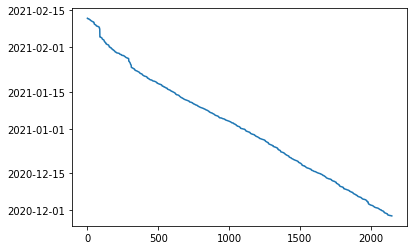

In [14]:
plt.plot(sorted([datetime.fromtimestamp(s['created_utc']) for s in submissions], reverse=True))

count     2149.000000
mean        34.529083
std        701.731178
min          0.000000
25%          1.000000
50%          1.000000
75%          1.000000
max      20204.000000
dtype: float64


<AxesSubplot:>

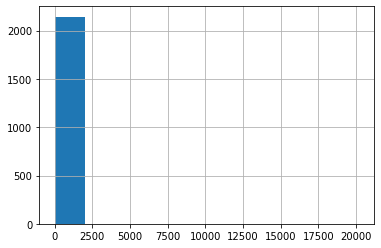

In [15]:
scores = pd.Series([s['score'] for s in submissions])
print(scores.describe())
scores.hist()